In [2]:
from Crypto.Cipher import Blowfish
from Crypto.Random import get_random_bytes
from hashlib import sha256
from Crypto.Util.Padding import pad, unpad
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives.serialization import (
    Encoding,
    PublicFormat,
    PrivateFormat,
    NoEncryption,
    load_pem_private_key,
)
import base64
import time
import os
import numpy as np
from collections import Counter
from scipy.stats import entropy
from matplotlib import pyplot as plt

In [3]:
def brute_force_attack(encrypted_data, known_plaintext, iv):
    print("\n=== BRUTE FORCE ATTACK SIMULATION ===")
    for _ in range(100000):  # Simulate multiple attempts
        random_key = get_random_bytes(Blowfish.key_size[0])  # Generate random key
        try:
            cipher = Blowfish.new(random_key, Blowfish.MODE_CBC, iv)
            decrypted_data = cipher.decrypt(encrypted_data)
            decrypted_data = unpad(decrypted_data, Blowfish.block_size)
            if known_plaintext in decrypted_data:
                print(f"Key found: {random_key}")
                return random_key
        except ValueError:
            continue  # Ignore errors for invalid decryption
    print("Key not found after 100,000 attempts.")
    return None

# Replay Attack Simulation
    '''
    Eğer saldırı başarılı olursa, "Replay Attack Successful" mesajı yazdırılır.
    Eğer sistem saldırıyı algılarsa, hata mesajı ile sonuçlanır.
    '''
def replay_attack(encryption_result):
    print("\n=== REPLAY ATTACK SIMULATION ===")
    try:
        decrypted_data = karma_decrypt(
            encryption_result["validated_data"],
            encryption_result["encrypted_metadata"],
            encryption_result["private_key"],
            encryption_result["key"],
            encryption_result["iv"],  # Ensure IV is used if required by the algorithm
        )
        print("Replay Attack Successful: Decrypted without error\n")
    except ValueError as e:
        print(f"Replay Attack Failed: {e}\n")

# Man-in-the-Middle Attack Simulation
#Şifrelenmiş veriyi manipüle ederek, alıcıyı kandırmaya ve veriyi doğrulatmaya çalışır.
def man_in_the_middle_attack(validated_data):
        try:
            tampered_data = validated_data[:-1] + b"0"  # Tamper with the last byte
            interleaved_data = verify_hash(tampered_data)
            if interleaved_data:
                print("Man-in-the-Middle Attack Successful: Tampered data validated\n")
            else:
                print("Man-in-the-Middle Attack Failed: Tampered data validation failed\n")
        except Exception as e:
            print(f"Man-in-the-Middle Attack Exception: {e}\n")

# Stolen Verifier Attack Simulation
'''
Şifrelenmiş verinin hash doğrulama bilgilerini manipüle ederek, yetkisiz erişim sağlamaya çalışır.
Verinin son baytı değiştirilir (tampered_data)
Hash doğrulama için kullanılan HMAC anahtarı, simetrik anahtardan türetilir
HMAC doğrulaması yapılır:
Eğer başarılıysa, veri şifre çözülür ve görüntülenir
Eğer başarısızsa, hata mesajı yazdırılır
'''
def stolen_verifier_attack(validated_data, symmetric_key, iv):
    print("\n=== STOLEN VERIFIER ATTACK SIMULATION ===")
    try:
        tampered_data = validated_data[:-1] + b"0"  # Simulate tampering
        hmac_key = sha256(symmetric_key).digest()  # Derive HMAC key
        verified_data = verify_hmac(tampered_data, hmac_key)

        if verified_data is None:
            raise ValueError("HMAC validation failed.")

        cipher = Blowfish.new(symmetric_key, Blowfish.MODE_CBC, iv)  # Ensure IV is used correctly
        decrypted_data = cipher.decrypt(verified_data)
        decrypted_data = unpad(decrypted_data, Blowfish.block_size)
        print(f"Stolen Verifier Attack Successful: {decrypted_data.decode()}\n")
    except Exception as e:
        print(f"Stolen Verifier Attack Failed: {e}\n")


In [4]:
# Entropy Calculation
#Bir veri kümesinin Shannon entropisini hesaplar. Entropi, verideki rastgelelik veya öngörülemezliği ölçer.
def calculate_entropy(data):
    if not data:
        return 0.0  # Girdi verisi boşsa 0.0 döndürülür.

    # Counter sınıfı kullanılarak her baytın (0–255) kaç kez geçtiği sayılır.
    freq = Counter(data)
    total_bytes = len(data)

    # Her baytın olasılığı, frekansının toplam bayt sayısına bölünmesiyle hesaplanır.
    probs = [count / total_bytes for count in freq.values()]

    # Sadece olasılığı 0'dan büyük olan değerler entropi hesaplamasına dahil edilir.
    return -sum(p * np.log2(p) for p in probs if p > 0)

# Key Sensitivity Analysis
# Şifrelemenin anahtardaki küçük değişikliklere karşı duyarlılığını test eder.
def key_sensitivity_test(data, key, iv, num_tests=5):
    """Analyzes key sensitivity by changing one bit in the key."""
    original_ciphertext = encrypt_fragment(data, key, iv)
    differences = []

    for i in range(num_tests):
        modified_key = bytearray(key)
        bit_position = np.random.randint(0, len(key) * 8) #Anahtarda rastgele bir bit pozisyonu seçilir.
        byte_index = bit_position // 8
        bit_index = bit_position % 8
        modified_key[byte_index] ^= (1 << bit_index) #Seçilen bit, XOR işlemiyle (^=) ters çevrilir.

        new_ciphertext = encrypt_fragment(data, bytes(modified_key), iv) #Veri, değiştirilmiş anahtarla şifrelenir.
        diff = sum(c1 != c2 for c1, c2 in zip(original_ciphertext, new_ciphertext)) #Orijinal ve yeni şifrelenmiş veri bayt bayt karşılaştırılır.
        differences.append(diff / len(original_ciphertext) * 100) #Farklı baytların sayısı yüzdelik olarak hesaplanır ve kaydedilir.

    return differences # Tüm testler için fark yüzdeleri bir liste olarak döndürülür.

# Plaintext Sensitivity Analysis
#Şifrelemenin metindeki küçük değişikliklere karşı duyarlılığını test eder.
def plaintext_sensitivity_test(data, key, iv, num_tests=5):
    """Analyzes plaintext sensitivity by changing one bit in the plaintext."""
    original_ciphertext = encrypt_fragment(data, key, iv)
    differences = []

    for i in range(num_tests):
        modified_data = bytearray(data)
        bit_position = np.random.randint(0, len(data) * 8)
        byte_index = bit_position // 8
        bit_index = bit_position % 8
        modified_data[byte_index] ^= (1 << bit_index)

        new_ciphertext = encrypt_fragment(bytes(modified_data), key, iv)
        diff = sum(c1 != c2 for c1, c2 in zip(original_ciphertext, new_ciphertext))
        differences.append(diff / len(original_ciphertext) * 100)

    return differences

# Frequency Analysis
#Verideki baytların frekans dağılımını analiz eder.
def frequency_analysis(data):
    """Performs frequency analysis on the given data."""
    freq = Counter(data)
    return freq

# Histogram Analysis
#Baytların frekans dağılımını histogram olarak görselleştirir.
def plot_histogram(data, title="Histogram Analysis"):
    """Plots the histogram of byte distribution in the data."""
    freq = frequency_analysis(data)
    plt.bar(freq.keys(), freq.values(), width=1.0)
    plt.title(title)
    plt.xlabel("Byte Value") #X ekseni: Bayt değerlerini (0–255) temsil eder.
    plt.ylabel("Frequency") #Y ekseni: Frekans değerlerini temsil eder.
    plt.show()

In [5]:
# Recursive Data Splitting
"""
Girdi verisini belirli bir boyutta (base_size) küçük parçalara ayırır.
Veri, her adımda base_size kadar dilimlenerek fragments listesine eklenir.
"""
def recursive_split(data, base_size=32):
    """
    Splits the input data into adaptive fragments based on data size and system capabilities.
    :param data: Input data to be fragmented
    :param base_size: Base fragment size
    :return: List of data fragments
    """
    # Determine the adaptive fragment size
    total_size = len(data)
    adaptive_size = max(base_size, total_size // (os.cpu_count() or 1))  # Minimum size is the base size
    adaptive_size = min(adaptive_size, 10 * base_size)  # Limit maximum fragment size

    fragments = []
    for i in range(0, len(data), adaptive_size):
        fragment = data[i:i + adaptive_size]
        fragments.append(fragment)
    print(f"Step 1: Split Data: {fragments}")
    print(f"Step 1: Adaptive split - {len(fragments)} fragments created with size range "
          f"{min(len(f) for f in fragments)}-{max(len(f) for f in fragments)} bytes.")
    return fragments


# Recursive Assembly
def recursive_assemble(fragments):
    print(f"Step 4: Combining Fragments: {fragments}")
    return b"".join(fragments)

In [6]:
# Interleaving
"""
Verileri daha dağınık ve karışık bir yapıya dönüştürmek.

"""
def interleave(fragments):
    interleaved = bytearray()
    max_length = max(len(frag) for frag in fragments)
    for i in range(max_length):  # En uzun parçanın uzunluğu kadar
        for frag in fragments:  # Her parçadan sırayla bayt al
            if i < len(frag):   # Parça boyutunun dışına çıkılmadığından emin ol
                interleaved.append(frag[i])  # Baytı interleaved'e ekle
    return interleaved

# Deinterleaving
def deinterleave(data, fragment_sizes):
    fragments = []
    num_fragments = len(fragment_sizes)
    max_length = max(fragment_sizes)
    idx = 0

    for size in fragment_sizes: #Parça uzunluklarına göre boş bytearray nesneleri hazırlanır.
        fragments.append(bytearray(size))

    try:
        for i in range(max_length): #Interleaved verinin uzunluğu kadar döner.
            for j in range(num_fragments): # Her fragmanın ilgili baytına veri ekler.
                if i < fragment_sizes[j]:
                    fragments[j][i] = data[idx]
                    idx += 1
    except IndexError:
        raise ValueError("Deinterleaving failed due to mismatch in data and fragment sizes.")

    return [bytes(frag) for frag in fragments]

In [7]:
# Self-Validating Fragments
#Parçaya bir SHA-256 hash ekleyerek bütünlüğü doğrulama sağlar.
def append_hash(fragment):
    hash_value = sha256(fragment).digest()
    return fragment + hash_value

def verify_hash(fragment):
    data, received_hash = fragment[:-32], fragment[-32:]
    computed_hash = sha256(data).digest()
    return data if computed_hash == received_hash else None

In [8]:
# ECC Key Management
def generate_ecc_keys():
    private_key = ec.generate_private_key(ec.SECP256R1())
    public_key = private_key.public_key()
    return private_key, public_key

# Nonce tracking for replay attack prevention
#Nonce'ları takip etmek için kullanılan bir set. Tekrar saldırılarını önlemek için nonce daha önce kullanılmışsa hata verir.
nonce_cache = set()

# Generate Nonce for Replay Protection
# Her şifreleme oturumu için rastgele 16 baytlık bir nonce oluşturur.
def generate_nonce():
    return os.urandom(16)


In [9]:
# Metadata’yı (ör. nonce ve IV) genel anahtar kullanarak şifreler
def encrypt_metadata(metadata, public_key):
    serialized_public_key = public_key.public_bytes(
        encoding=Encoding.PEM, #Genel anahtar PEM formatında serileştirilir.
        format=PublicFormat.SubjectPublicKeyInfo
    )
    encoded_metadata = metadata.encode()
    return base64.b64encode(serialized_public_key + b"||" + encoded_metadata) #Serileştirilmiş anahtar ve metadata birleştirilip Base64 kodlanır.

def decrypt_metadata(encrypted_metadata, private_key):
    combined = base64.b64decode(encrypted_metadata)
    _, metadata = combined.split(b"||", 1)
    return metadata.decode()

In [10]:
#Bir parçayı CBC modunda Blowfish algoritmasıyla şifreler.
def encrypt_fragment(fragment, key, iv):
    padded_fragment = pad(fragment, Blowfish.block_size)  # PKCS7 padding
    cipher = Blowfish.new(key, Blowfish.MODE_CBC, iv) #Dolgulu parça, verilen anahtar ve IV kullanılarak şifrelenir.
    return cipher.encrypt(padded_fragment)

def decrypt_fragment(fragment, key, iv):
    cipher = Blowfish.new(key, Blowfish.MODE_CBC, iv)
    decrypted_data = cipher.decrypt(fragment)
    return unpad(decrypted_data, Blowfish.block_size)  # Remove PKCS7 padding


=== Encrypting Data ===

=== ENCRYPTION ===
Generated IV: 963b20f232d83d65
Step 1: Split Data: [b'Example plaint', b'ext data to en', b'crypt using Ka', b'rma Encryption', b'!']
Step 1: Adaptive split - 5 fragments created with size range 1-14 bytes.
Step 1: Fragments after recursive splitting: [14, 14, 14, 14, 1]

Step 2: Data after interleaving (before encryption): bytearray(b'Eecr!xxrmatyam p pdtEla netuc asrp iyltnpaogti  ineKotnan')

Generated Key: da6751e0eec373b666
Step 3: Encrypted interleaved data: 0c81b7ca20e0b33ac7ce45d5a1b07ec5b41ba75ed2813a9e6f8f1b96eab66917d0b3afeaf7d952d728b5e86378ad0e9dac098d6329e20a0e370a4816181f6ed1

Step 4: Data with appended hash: 0c81b7ca20e0b33ac7ce45d5a1b07ec5b41ba75ed2813a9e6f8f1b96eab66917d0b3afeaf7d952d728b5e86378ad0e9dac098d6329e20a0e370a4816181f6ed14de51dba9bf25b5c49d33cb42a88c582ac693f0c83c5f5e8e72bd65c56fc07df

Step 5: Encrypted metadata: LS0tLS1CRUdJTiBQVUJMSUMgS0VZLS0tLS0KTUZrd0V3WUhLb1pJemowQ0FRWUlLb1pJemowREFRY0RRZ0FFVTJzWTZGazN6emRleW

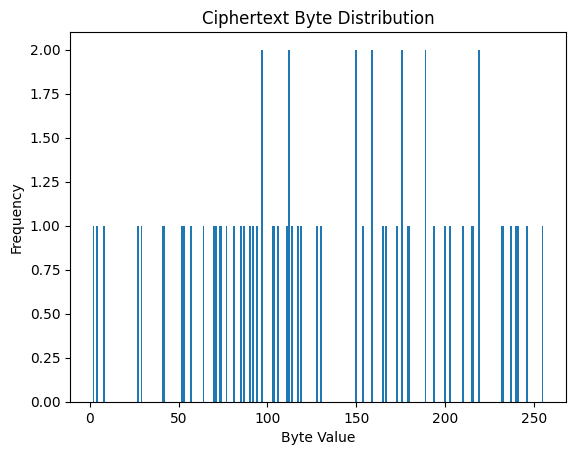


=== Running Brute Force Attack ===
Key not found after 100,000 attempts.

=== Running Replay Attack ===

=== DECRYPTION ===
Step 1: Decrypted metadata: nonce=11e7630d8561e5b5b4aa036f46faf638,iv=963b20f232d83d65

Step 1: Extracted Nonce: 11e7630d8561e5b5b4aa036f46faf638
Replay Attack Failed: Replay attack detected: Nonce has already been used.


=== DECRYPTION ===
Step 1: Decrypted metadata: nonce=11e7630d8561e5b5b4aa036f46faf638,iv=963b20f232d83d65

Step 1: Extracted Nonce: 11e7630d8561e5b5b4aa036f46faf638
Replay Attack Failed: Replay attack detected: Nonce has already been used.


=== Running Man-in-the-Middle Attack ===
Man-in-the-Middle Attack Failed: Tampered data validation failed


=== Running Stolen Verifier Attack ===

=== STOLEN VERIFIER ATTACK SIMULATION ===
Stolen Verifier Attack Failed: name 'verify_hmac' is not defined



In [11]:
# Karma Encrypt
"""
validated_data: Hash eklenmiş şifrelenmiş veri.
encrypted_metadata: Şifrelenmiş metadata (nonce ve IV).
private_key: ECC özel anahtarı.
key: Blowfish simetrik anahtarı.
iv: Başlangıç vektörü.
fragment_sizes: Orijinal parçaların boyutları.
IV: Aynı veri tekrar tekrar şifrelenirse, şifrelenmiş çıktılar (ciphertext) aynı olur.
IV, bu durumu önler ve aynı verinin şifrelenmesi durumunda bile farklı çıktılar oluşturur.
"""
def karma_encrypt(data, base_size=32):
    print("\n=== ENCRYPTION ===")

    start_time = time.time()

    iv = get_random_bytes(Blowfish.block_size)
    print(f"Generated IV: {iv.hex()}")

    fragments = recursive_split(data, base_size)
    print(f"Step 1: Fragments after recursive splitting: {[len(f) for f in fragments]}\n")

    interleaved_data = interleave(fragments)
    print(f"Step 2: Data after interleaving (before encryption): {interleaved_data}\n")

    key = get_random_bytes(Blowfish.key_size[5])
    print(f"Generated Key: {key.hex()}")
    encrypted_data = encrypt_fragment(interleaved_data, key, iv)
    print(f"Step 3: Encrypted interleaved data: {encrypted_data.hex()}\n")

    validated_data = append_hash(encrypted_data)
    print(f"Step 4: Data with appended hash: {validated_data.hex()}\n")

    nonce = generate_nonce()
    metadata = f"nonce={nonce.hex()},iv={iv.hex()}"
    private_key, public_key = generate_ecc_keys()
    encrypted_metadata = encrypt_metadata(metadata, public_key)
    print(f"Step 5: Encrypted metadata: {encrypted_metadata.decode()}\n")

    end_time = time.time()
    print(f"Encryption Time: {end_time - start_time:.4f} seconds\n")

    nonce_cache.add(nonce.hex())

    return {
        "validated_data": validated_data,
        "encrypted_metadata": encrypted_metadata,
        "private_key": private_key.private_bytes(
            Encoding.PEM, PrivateFormat.PKCS8, NoEncryption()
        ),
        "key": key,
        "iv": iv,
        "fragment_sizes": [len(f) for f in fragments],
    }

# Karma Decrypt
def karma_decrypt(validated_data, encrypted_metadata, private_key_bytes, symmetric_key, iv, fragment_sizes):
    print("\n=== DECRYPTION ===")

    start_time = time.time()

    private_key = load_pem_private_key(private_key_bytes, password=None)
    metadata = decrypt_metadata(encrypted_metadata, private_key)
    print(f"Step 1: Decrypted metadata: {metadata}\n")

    metadata_parts = {k: v for k, v in [item.split("=") for item in metadata.split(",")]}
    nonce = metadata_parts["nonce"]
    print(f"Step 1: Extracted Nonce: {nonce}")
    if nonce in nonce_cache:
        raise ValueError("Replay attack detected: Nonce has already been used.")
    nonce_cache.add(nonce)

    interleaved_data = verify_hash(validated_data)
    if interleaved_data is None:
        raise ValueError("Data integrity check failed.")
    print(f"Step 2: Validated interleaved data: {interleaved_data}\n")

    decrypted_interleaved = decrypt_fragment(interleaved_data, symmetric_key, iv)
    print(f"Step 3: Decrypted interleaved data: {decrypted_interleaved}\n")

    fragments = deinterleave(decrypted_interleaved, fragment_sizes)
    print(f"Step 3: Reassembled fragments - {len(fragments)} fragments with size range "
          f"{min(len(f) for f in fragments)}-{max(len(f) for f in fragments)} bytes.")
    decrypted_data = recursive_assemble(fragments)
    print(f"Step 4: Decrypted data: {decrypted_data}\\n")

    end_time = time.time()
    print(f"Decryption Time: {end_time - start_time:.4f} seconds\n")

    return decrypted_data

if __name__ == "__main__":
    # Input data
    data = b"Example plaintext data to encrypt using Karma Encryption!"
    key = get_random_bytes(Blowfish.key_size[5])
    iv = get_random_bytes(Blowfish.block_size)

    # Encryption Step
    print("=== Encrypting Data ===")
    try:
        encryption_result = karma_encrypt(data, base_size=8)
        print(f"Encryption completed. Fragment sizes: {encryption_result['fragment_sizes']}")
    except Exception as e:
        print(f"Encryption failed: {e}")
        raise

    # Ensure encryption_result is defined
    if not encryption_result or "validated_data" not in encryption_result:
        raise ValueError("Encryption result is undefined or invalid.")

    # Decrypt and Display Results
    print("\n=== Decrypting Data ===")
    try:
        nonce_cache.clear()
        decrypted_data = karma_decrypt(
            encryption_result["validated_data"],
            encryption_result["encrypted_metadata"],
            encryption_result["private_key"],
            encryption_result["key"],
            encryption_result["iv"],
            encryption_result["fragment_sizes"]
        )
        print(f"Decrypted Data:\n{decrypted_data.decode()}\n")
    except ValueError as e:
        print(f"Decryption Failed: {e}\n")
    except Exception as e:
        print(f"An unexpected error occurred during decryption: {e}")


    # Entropy
    encrypted_data = encrypt_fragment(data, key, iv)
    data_entropy = calculate_entropy(encrypted_data)
    print(f"Ciphertext Entropy: {data_entropy:.4f}")

    # Key Sensitivity
    key_sensitivity = key_sensitivity_test(data, key, iv)
    print(f"Key Sensitivity (Percentage Differences): {key_sensitivity}")

    # Plaintext Sensitivity
    plaintext_sensitivity = plaintext_sensitivity_test(data, key, iv)
    print(f"Plaintext Sensitivity (Percentage Differences): {plaintext_sensitivity}")

    # Frequency Analysis
    freq = frequency_analysis(encrypted_data)
    print(f"Frequency Analysis: {freq}")

    # Histogram Analysis
    plot_histogram(encrypted_data, title="Ciphertext Byte Distribution")

    # Brute Force Attack
    print("\n=== Running Brute Force Attack ===")
    def brute_force_attack(encrypted_data, known_plaintext, iv):
        for _ in range(100000):  # Simulate multiple attempts
            random_key = get_random_bytes(Blowfish.key_size[5])  # Generate random key
            try:
                decrypted_interleaved = decrypt_fragment(encrypted_data, random_key, iv)
                if known_plaintext in decrypted_interleaved:
                    print(f"Key found: {random_key.hex()}")
                    return random_key
            except ValueError:
                continue
        print("Key not found after 100,000 attempts.")
        return None

    brute_force_attack(
        encryption_result["validated_data"],
        b"Example plaintext data",
        encryption_result["iv"]
    )

    # Replay Attack
    print("\n=== Running Replay Attack ===")
    def replay_attack(encryption_result):
        try:
            karma_decrypt(
                encryption_result["validated_data"],
                encryption_result["encrypted_metadata"],
                encryption_result["private_key"],
                encryption_result["key"],
                encryption_result["iv"],
                encryption_result["fragment_sizes"]
            )
            print("Replay Attack Successful: Decrypted without error\n")
        except ValueError as e:
            print(f"Replay Attack Failed: {e}\n")

    try:
        replay_attack(encryption_result)
        replay_attack(encryption_result)  # Test nonce reuse
    except ValueError as e:
        print(f"Expected Replay Attack Detection: {e}\n")

    # Man-in-the-Middle Attack
    print("\n=== Running Man-in-the-Middle Attack ===")
    

    man_in_the_middle_attack(encryption_result["validated_data"])

    # Stolen Verifier Attack
    print("\n=== Running Stolen Verifier Attack ===")
    
    stolen_verifier_attack(
        encryption_result["validated_data"],
        encryption_result["key"],
        encryption_result["iv"]
    )

In [12]:
def encrypt_file(input_file, output_file, base_size=32):
    """
    Encrypts the input file and writes the encrypted data to the output file.
    :param input_file: Path to the input file
    :param output_file: Path to the output encrypted file
    :param base_size: Base size for fragments
    :return: Encryption result (including key, IV, and other metadata)
    """
    try:
        # Read input file
        with open(input_file, 'rb') as f:
            data = f.read()

        # Dynamically calculate fragment size
        total_size = len(data)
        adaptive_size = max(base_size, total_size // (os.cpu_count() or 1))
        adaptive_size = min(adaptive_size, 10 * base_size)

        # Split data into adaptive fragments
        fragments = recursive_split(data, adaptive_size)

        # Encrypt the data
        encryption_result = karma_encrypt(data, base_size=adaptive_size)

        # Save the encrypted data
        with open(output_file, 'wb') as f:
            f.write(encryption_result["validated_data"])

        print(f"Encryption completed. Data split into {len(fragments)} fragments with size range "
              f"{min(len(f) for f in fragments)}-{max(len(f) for f in fragments)} bytes.")

        return encryption_result

    except Exception as e:
        print(f"Encryption failed: {e}")
        raise


def decrypt_file(input_file, output_file, encryption_result):
    """
    Decrypts the input file and writes the decrypted data to the output file.
    :param input_file: Path to the input encrypted file
    :param output_file: Path to the output decrypted file
    :param encryption_result: Metadata from the encryption step
    """
    try:
        # Read encrypted data
        with open(input_file, 'rb') as f:
            validated_data = f.read()

        # Clear nonce cache to simulate independent decryption
        nonce_cache.clear()

        # Decrypt the data
        decrypted_data = karma_decrypt(
            validated_data,
            encryption_result["encrypted_metadata"],
            encryption_result["private_key"],
            encryption_result["key"],
            encryption_result["iv"],
            encryption_result["fragment_sizes"]
        )

        # Save the decrypted data
        with open(output_file, 'wb') as f:
            f.write(decrypted_data)

        print(f"Decryption completed. Output saved to {output_file}.")

    except KeyError as e:
        print(f"Decryption failed: Missing key in encryption result - {e}")
        raise
    except Exception as e:
        print(f"Decryption failed: {e}")
        raise


=== Encrypting File ===
Step 1: Split Data: [b"Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since t", b'he 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries,', b' but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset s', b'heets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsu', b'm.']
Step 1: Adaptive split - 5 fragments created with size range 2-143 bytes.

=== ENCRYPTION ===
Generated IV: 4dc11cdc90f23845
Step 1: Split Data: [b"Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since t", b'he 1500s, when an unknown printer took a galley of type and 

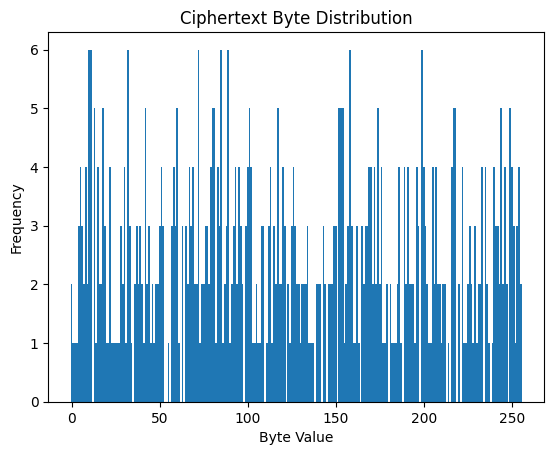


=== Brute Force Attack Simulation ===
Key not found after 100,000 attempts.

=== Replay Attack Simulation ===

=== DECRYPTION ===
Step 1: Decrypted metadata: nonce=e0091d77ac4080b6f36d349083c8de42,iv=4dc11cdc90f23845

Step 1: Extracted Nonce: e0091d77ac4080b6f36d349083c8de42
Replay Attack Failed: Replay attack detected: Nonce has already been used.


=== Man-in-the-Middle Attack Simulation ===
Man-in-the-Middle Attack Failed: Tampered data validation failed


=== STOLEN VERIFIER ATTACK SIMULATION ===
Stolen Verifier Attack Failed: name 'verify_hmac' is not defined



In [13]:
# Main Function
if __name__ == "__main__":
    # Paths for the files
    input_file = "code_explanation.txt"
    encrypted_file = "example_encrypted.dat"
    decrypted_file = "example_decrypted.txt"

    # Ensure the input file exists
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file '{input_file}' not found.")

    # Encrypt the file
    print("=== Encrypting File ===")
    encryption_result = encrypt_file(input_file, encrypted_file)
    print(f"File encrypted and saved as {encrypted_file}")

    # Decrypt the file
    print("=== Decrypting File ===")
    decrypt_file(encrypted_file, decrypted_file, encryption_result)
    print(f"File decrypted and saved as {decrypted_file}")

    # Analyze Metrics
    print("\n=== Metrics Analysis ===")
    with open(input_file, 'rb') as f:
        original_data = f.read()

    encrypted_data = encryption_result["validated_data"]
    key = encryption_result["key"]
    iv = encryption_result["iv"]

    # Entropy
    entropy_value = calculate_entropy(encrypted_data)
    print(f"Ciphertext Entropy: {entropy_value:.4f}")

    # Key Sensitivity Analysis
    key_sensitivity = key_sensitivity_test(original_data, key, iv)
    print(f"Key Sensitivity (Percentage Differences): {key_sensitivity}")

    # Plaintext Sensitivity Analysis
    plaintext_sensitivity = plaintext_sensitivity_test(original_data, key, iv)
    print(f"Plaintext Sensitivity (Percentage Differences): {plaintext_sensitivity}")

    # Frequency Analysis
    freq = frequency_analysis(encrypted_data)
    print(f"Frequency Analysis: {freq}")

    # Histogram Analysis
    plot_histogram(encrypted_data, title="Ciphertext Byte Distribution")

    # Brute Force Attack Simulation
    print("\n=== Brute Force Attack Simulation ===")
    known_plaintext = b"Some Known Plaintext"
    brute_force_attack(encrypted_data, known_plaintext, iv)

    # Replay Attack Simulation
    print("\n=== Replay Attack Simulation ===")
    replay_attack(encryption_result)

    # Man-in-the-Middle Attack Simulation
    print("\n=== Man-in-the-Middle Attack Simulation ===")
    man_in_the_middle_attack(encrypted_data)

    # Stolen Verifier Attack Simulation
    stolen_verifier_attack(encrypted_data, key, iv)


In [14]:
def process_image(image_path, encrypted_path, decrypted_path):
    # Encrypt the image
    print("=== Encrypting Image ===")
    encryption_result = encrypt_file(image_path, encrypted_path, base_size=64)  # Pass a base_size
    print(f"Image encrypted and saved as {encrypted_path}")

    # Decrypt the image
    print("=== Decrypting Image ===")
    decrypt_file(encrypted_path, decrypted_path, encryption_result)
    print(f"Image decrypted and saved as {decrypted_path}")

    # Check the results
    original_size = os.path.getsize(image_path)
    decrypted_size = os.path.getsize(decrypted_path)
    print(f"Original Image Size: {original_size} bytes")
    print(f"Decrypted Image Size: {decrypted_size} bytes")
    
    if original_size == decrypted_size:
        print("Success: The decrypted image matches the original.")
    else:
        print("Failure: The decrypted image does not match the original.")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Key Sensitivity (Percentage Differences): [99.62660820015135, 99.62688643547166, 99.60073231536303, 99.60685349240974, 99.61380937541735]
Ciphertext Entropy: 7.9995
Plaintext Sensitivity (Percentage Differences): [79.93116458175666, 32.555480122868715, 74.26128522459156, 91.84214040867204, 81.07638116013]
Frequency Analysis: Counter({161: 1507, 156: 1506, 252: 1495, 9: 1488, 83: 1487, 128: 1484, 25: 1480, 34: 1479, 232: 1478, 249: 1472, 137: 1471, 114: 1465, 42: 1465, 136: 1464, 10: 1464, 133: 1460, 11: 1459, 30: 1456, 243: 1454, 165: 1452, 117: 1450, 230: 1450, 73: 1448, 157: 1447, 21: 1447, 134: 1446, 231: 1446, 188: 1445, 246: 1445, 245: 1445, 82: 1444, 255: 1444, 93: 1442, 58: 1442, 148: 1442, 79: 1441, 140: 1440, 75: 1440, 183: 1439, 181: 1438, 138: 1438, 139: 1437, 121: 1436, 251: 1436, 29: 1436, 187: 1435, 152: 1435, 227: 1434, 197: 1434, 67: 1434, 172: 1433, 17: 1433, 191: 1433, 253: 1433, 192: 1433, 247: 1432, 215: 1431, 174: 1431, 190: 1431, 177: 1431, 160: 1430, 155: 1429, 5

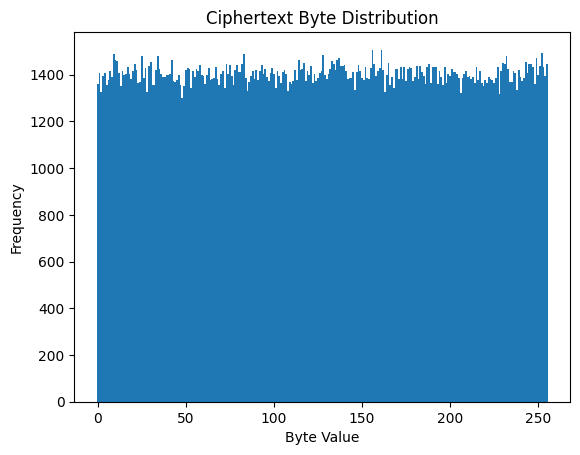

Key not found after 100,000 attempts.

=== DECRYPTION ===
Step 1: Decrypted metadata: nonce=f02e05fb93716cee0205e130303541e1,iv=669f6a88fe92c347

Step 1: Extracted Nonce: f02e05fb93716cee0205e130303541e1
Replay Attack Failed: Replay attack detected: Nonce has already been used.

Man-in-the-Middle Attack Failed: Tampered data validation failed


=== STOLEN VERIFIER ATTACK SIMULATION ===
Stolen Verifier Attack Failed: name 'verify_hmac' is not defined



In [15]:
if __name__ == "__main__":
    # Paths for the test image and resulting files
    image_path = "nature5.jpg"  # Replace with your image file
    encrypted_image_path = "test_image_encrypted1.dat"
    decrypted_image_path = "test_image_decrypted1.jpg"

    # Ensure the image file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found.")

    # Encrypt the image
    try:
        print("=== Encrypting Image ===")
        encryption_result = encrypt_file(image_path, encrypted_image_path, base_size=64)
        print(f"Image encrypted and saved as {encrypted_image_path}")
    except Exception as e:
        print(f"Encryption failed: {e}")
        raise

    # Log fragment sizes
    fragment_sizes = encryption_result.get("fragment_sizes", [])
    if fragment_sizes:
        print(f"Fragmentation: {len(fragment_sizes)} fragments, Size range: "
              f"{min(fragment_sizes)}-{max(fragment_sizes)} bytes")

    # Decrypt the image
    try:
        print("=== Decrypting Image ===")
        decrypt_file(encrypted_image_path, decrypted_image_path, encryption_result)
        print(f"Image decrypted and saved as {decrypted_image_path}")
    except Exception as e:
        print(f"Decryption failed: {e}")
        raise

    # Perform analysis (unchanged)
    # ... (Metrics Analysis)


    # Analyze Metrics
    with open(image_path, 'rb') as f:
        original_data = f.read()

    encrypted_data = encryption_result["validated_data"]
    key = encryption_result["key"]
    iv = encryption_result["iv"]

    print("\n=== Metrics Analysis ===")

    # Key Sensitivity
    key_sensitivity = key_sensitivity_test(original_data, key, iv)
    print(f"Key Sensitivity (Percentage Differences): {key_sensitivity}")
    # Entropy
    entropy_value = calculate_entropy(encrypted_data)
    print(f"Ciphertext Entropy: {entropy_value:.4f}")
    # Plaintext Sensitivity
    plaintext_sensitivity = plaintext_sensitivity_test(original_data, key, iv)
    print(f"Plaintext Sensitivity (Percentage Differences): {plaintext_sensitivity}")

    # Frequency Analysis
    freq = frequency_analysis(encrypted_data)
    print(f"Frequency Analysis: {freq}")

    # Histogram Analysis
    plot_histogram(encrypted_data, title="Ciphertext Byte Distribution")

    # Brute Force Attack Simulation
    known_plaintext = b"Some Known Plaintext"
    brute_force_attack(encryption_result["validated_data"], known_plaintext, encryption_result["iv"])

    # Replay Attack Simulation
    replay_attack(encryption_result)

    # Man-in-the-Middle Attack Simulation
    man_in_the_middle_attack(encryption_result["validated_data"])

    # Stolen Verifier Attack Simulation
    stolen_verifier_attack(encryption_result["validated_data"], encryption_result["key"], encryption_result["iv"])
